In this notebook we will build a pipeline to prepare DICOM MRI images and associated contour files\* for use as the input data and targets, respectively, to train a convolutional neural network.

** Part One **

In order to accomplish our goal we will start with the following steps:
- parse DICOM images and i-contour files
- translate parsed contour files to boolean mask
- pair associated images and files


\* Not every DICOM image may have an associated contour file, and vice versa.

In [64]:
from parsing import *
import numpy as np
import os

''' Let's start by loading DICOM-contour map into memory.
Will build a map from patiend_id (DICOM subdir) to original_id (contour subdir).
'''
def get_DICOM_map():
    link_map = {}
    with open('final_data/link.csv', 'r') as link:
        header = link.readline()
        for line in link:
            line = line.strip().split(',')
            link_map[line[0]] = line[1]
    print("Finished patient_id - original_id (DICOM - contours) link.")
    return link_map


''' Now lets assemble our data (DICOM images)
To do this I will use a map from patiend_id (DICOM subdir) to a map of DICOM name to DICOM data
i.e. {p_id -> {DICOM_id -> DICOM_data}}
'''
def get_DICOM_data():
    # Load DICOM data from disk
    DICOM_map = {}
    DICOM_dir = 'final_data/dicoms/'
    for subdir in os.listdir(DICOM_dir):
        path = os.path.join(DICOM_dir, subdir)
        if not os.path.isdir(path): continue
        DICOM_map[subdir] = {}
        for filename in os.listdir(path):
            # here we make use of 'parse_dicom_file' method from starter code in parsing.py
            dcm_dict = parse_dicom_file(os.path.join(path, filename))
            dcm_id = int(filename.split('.')[0])
            DICOM_map[subdir][dcm_id] = dcm_dict['pixel_data']
        print("Have %d dicoms for patient %s." % (len(DICOM_map[subdir]), subdir))
    print("Finished loading DICOM data.")
    return DICOM_map
    
    
''' Finally lets follow suit on contour data, much as above
{o_id -> {contour_id -> contour_data*}}

* note that we will transform contour data to its boolean mask 
in place and store that.
'''
def get_contour_data():
    # Load contour data from disk
    contour_map = {}
    contour_dir = 'final_data/contourfiles/'
    for subdir in os.listdir(contour_dir):
        path = os.path.join(contour_dir, subdir)
        if not os.path.isdir(path): continue
        contour_map[subdir] = {}
        # ignore o-contours, hard-code in contour type of interest
        path = os.path.join(path, 'i-contours')
        for filename in os.listdir(path):
            filepath = os.path.join(path, filename)
            if not os.path.isfile(filepath) or not filename.endswith('.txt'): continue
            # make use of 'parse_contour_file' and 'poly_to_mask' methods from starter code
            coords_list = parse_contour_file(filepath)
            # transformation to boolean mask
            mask = poly_to_mask(coords_list, 256, 256)
            contour_id = int(filename.split('-')[2])
            contour_map[subdir][contour_id] = mask
        print("Have %d contours for original id %s." % (len(contour_map[subdir]), subdir))
    print("Finished loading contour data.")
    return contour_map   
    
links = get_DICOM_map()
dicoms = get_DICOM_data()
contours = get_contour_data()


Finished patient_id - original_id (DICOM - contours) link.
Have 240 dicoms for patient SCD0000101.
Have 260 dicoms for patient SCD0000201.
Have 200 dicoms for patient SCD0000301.
Have 220 dicoms for patient SCD0000401.
Have 220 dicoms for patient SCD0000501.
Finished loading DICOM data.
Have 18 contours for original id SC-HF-I-1.
Have 18 contours for original id SC-HF-I-2.
Have 20 contours for original id SC-HF-I-4.
Have 18 contours for original id SC-HF-I-5.
Have 22 contours for original id SC-HF-I-6.
Finished loading contour data.


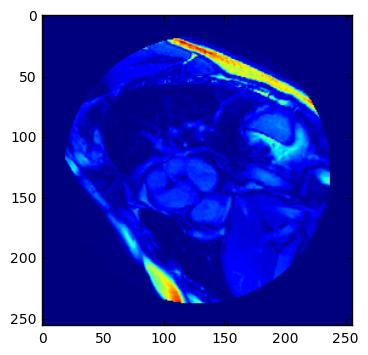

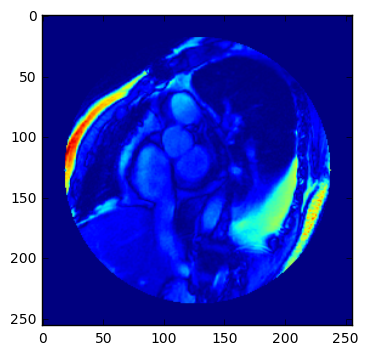

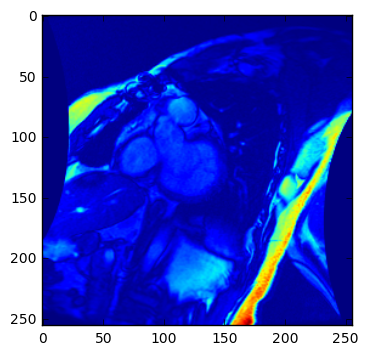

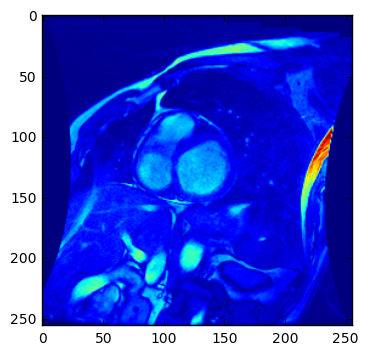

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

# Let's visualize some of these DICOM images
def preview():
    for i in range(1,6):
        if i == 3: continue
        subdir = 'SCD0000%d01' % i
        plt.figure()
        plt.imshow(dicoms[subdir][1])

preview()

In [65]:
import filecmp, random

''' Check parsing contour correctly by comparing derived file 
from coordinates list against original file using filecmp 
'''
def compare_contour(original_filepath):
    #print(original_filepath)
    coords_list = parse_contour_file(original_filepath)
    with open("test_file", 'w') as testfile:
        for coords in coords_list:
            line = '%.2f %.2f\n' % (coords[0], coords[1])
            testfile.write(line)
    if filecmp.cmp(original_filepath, "test_file"): print("Comparison passed.")
    else: print("Error: comparison failed on %s." % original_filepath)

# testing random contour files
def test(n=5):
    contour_dir = 'final_data/contourfiles'
    contour_type = 'i-contours'
    for i in range(n):
        subdir = random.choice(os.listdir(contour_dir))
        while subdir[0] == '.': subdir = random.choice(os.listdir(contour_dir))
        path = os.path.join(contour_dir, subdir, contour_type)
        filename = random.choice(os.listdir(path))
        while filename[0] == '.': filename = random.choice(os.listdir(path))
        filepath = os.path.join(path, filename)
        compare_contour(filepath)


test(10)

Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.
Comparison passed.


Now that we have loaded the data correctly, let us pair associated DICOM image data and target contour data. 

In [66]:
# Now let us build a data set for our CNN of associated DICOM - contour pairs.

def build_dataset():
    X, y = [], []
    for patient_id, original_id in links.items():
        count = 0
        for dcm_id in dicoms[patient_id]:
            if dcm_id in contours[original_id]:
                X.append(dicoms[patient_id][dcm_id])
                y.append(contours[original_id][dcm_id])
                count += 1
        print("Found %d matches out of %d DICOMS and %d contours." % (count, len(dicoms[patient_id]), len(contours[original_id])))
    return np.array(X), np.array(y)
    
train_x, train_y = build_dataset()
print("\nTrain DICOM data shape: ", train_x.shape)
print("Train contour target shape: ", train_y.shape)

Found 18 matches out of 260 DICOMS and 18 contours.
Found 18 matches out of 220 DICOMS and 18 contours.
Found 22 matches out of 220 DICOMS and 22 contours.
Found 20 matches out of 200 DICOMS and 20 contours.
Found 18 matches out of 240 DICOMS and 18 contours.

Train DICOM data shape:  (96, 256, 256)
Train contour target shape:  (96, 256, 256)


Evidently for every contour we have image data but hardly so in the other direction. I imagine this is not unexpected in this field in which we know there to be vast unlabeled data, nevertheless not ideal for our supervised learning task.

**Part One Questions**

In order to verify that we are parsing the contours correctly I first examined the provided parse_contour_file function which does the parsing. Fortunately, all was in order there however as a fail safe I reconstructed contour text files from the parsed coordinates and did equality comparison against the original contour files using the import filecmp operator. As this also proved to function smoothly over and over again, I felt confident it was working properly and moved on. 
I had to make no changes to the starter code before integrating it!

** Part Two **

Now that we have the data, the next step is to load batches of this data for input into a 2D deep learning model. In specific, we want to cycle over the entire dataset, loading a single batch (e.g. 8 observations) of inputs (DICOM image data) and targets (boolean masks) at each training step.

To note:
- A single batch of data will consist of one numpy array for images and one numpy array for targets, e.g. (batch_size, 256, 256)
- Within each epoch (e.g. iteration over all studies once), samples from a batch should be loaded randomly from the entire dataset.

In [77]:
import math

# Now we develop a method to load batches of our data so we can later run our model

def run_model(nepochs=1, batch_size=8):       
    iters = 0  
    for epoch in range(nepochs):
        # shuffle indices each epoch so as to have random order every time
        train_indices = np.arange(train_x.shape[0])
        np.random.shuffle(train_indices)

        # make sure we cycle over the dataset once, loading single batch at each step
        for i in range(int(math.ceil(train_x.shape[0] / batch_size))):
            # generate indices for the batch
            start_idx = i*batch_size
            idx = train_indices[start_idx:start_idx+batch_size]
            print("On iteration %d have batch following indices: " % iters, idx)
            # generate batches which can be fed into model
            X, y = train_x[idx], train_y[idx]     
            iters += 1

run_model()

On iteration 0 have batch following indices:  [48 24 16 80 47 60 28 81]
On iteration 1 have batch following indices:  [ 7 57 90 14 13 54 59 17]
On iteration 2 have batch following indices:  [75 52  2 35 72 37 88 20]
On iteration 3 have batch following indices:  [69 32 76 62 89 39 36 56]
On iteration 4 have batch following indices:  [30 83 93 95 46  8 40  9]
On iteration 5 have batch following indices:  [77 78 84 67 55 21 34 94]
On iteration 6 have batch following indices:  [15  1 22 91 63 82 42 73]
On iteration 7 have batch following indices:  [ 0 58 87  5 64 49 25 65]
On iteration 8 have batch following indices:  [86 41 19 43  6 92 31 11]
On iteration 9 have batch following indices:  [85 27  4 70 44 68 12 51]
On iteration 10 have batch following indices:  [66 10 45 50 23 26 61 33]
On iteration 11 have batch following indices:  [53 79  3 71 18 38 29 74]


**Part Two Questions**

- I did not have to change anything from Part One in order to build Part Two - in fact I didn't really think about it. Going forward, however, and having a slightly better idea of the type of data this is, I would think that it is unnecessary to load in all DICOM data. Given that clearly there is a bottleneck on the contour targets, I might in the future load contour data and then only load DICOM data for which we have the targets to save space and time (both in the loading of DICOM data and eliminating second loop over data in my current build_dataset function).

- I verified this part of the pipeline was working by printing out which indices of the training data I was including in each batch. I had to ensure that 1) in each epoch I got every example (i.e. every index), 2) I would get random training examples in every batch and every epoch, and 3) that by slicing into my training arrays I could output the correct data (this last part I proved to myself mostly by dimension checking).

- Given this pipeline, I think we have a nice method to run our model (i.e. feed in the appropriate training examples at each iteration) but as I mentioned before the loading of the data is somewhat inefficient. Given that I already spoke to that above, I would only add that I think the main focus of mine going forward would be in how to augment our training data and/or make use of unlabeled data.